In [ ]:
!pip install fsspec
!pip install gcsfs
!pip install transformers
!pip install sentence_transformers
!pip install faiss
!python -m pip install --upgrade faiss faiss-gpu
!pip install p_tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.6 MB/s 
     |████████████████████████████████| 94 kB 1.8 MB/s 
     |████████████████████████████████| 144 kB 12.7 MB/s 
     |████████████████████████████████| 271 kB 43.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 101 kB 12.4 MB/s 
     |████████████████████████████████| 596 kB 57.1 MB/s 
     |████████████████████████████████| 6.6 MB 28.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Colab Notebooks/tfm"
import sys
sys.path.append('tfm/checkpoints/')
sys.path.append('tfm/outputs/')

Mounted at /content/drive


In [ ]:
import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from p_tqdm import p_map
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    roc_auc_score,
)
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from tqdm.auto import tqdm
from transformers import AutoTokenizer, TFBertForSequenceClassification

In [ ]:
filepath = "../../data/outputs/dataset_2021_paragraph"
filepath = "tfm/outputs/dataset_2021_paragraph" # Filepath COLAB
filepath = "https://storage.googleapis.com/tfm_aideas_datasets/dataset_2021_paragraph" # Filepath GCloud

In [ ]:
#### Código para migrar las labels del dataset original etiquetado al nuevo dataset_2021_paragraph_annotated ####
#### Mejor no ejecutar en COLAB para guardar CSV ####
df_no_labels = pd.read_csv(f"{filepath}.csv", sep=";", index_col=0, parse_dates=["date"])

df_hg = pd.read_csv("tfm/outputs/hg_subdataset_paragraph_etiquetado.csv", sep=";", parse_dates=["date"])
df_rs = pd.read_csv("tfm/outputs/rs_subdataset_paragraph_etiquetado.csv", sep=";", parse_dates=["date"])
df_annotated_labels = pd.concat([df_hg,df_rs]).reset_index(drop=True)

old_columns = ["finanzas_news_s_n", "impacto_news_s_n", "topic", "finanzas_s_n", "impacto_s_n"]
new_columns = ["finanzas_tag_news_s_n", "impacto_tag_news_s_n", "topic_tag_news", "finanzas_tag_s_n", "impacto_tag_s_n"]

notna_indexes = df_annotated_labels.loc[:,old_columns].dropna().index
df_annotated_labels = df_annotated_labels.loc[notna_indexes,:]

for idx, row in df_annotated_labels.iterrows():
    for old_label, new_label in zip(old_columns, new_columns):
        df_no_labels.loc[(df_no_labels.body == row.body) & (df_no_labels.title == row.title), new_label] = df_annotated_labels.loc[idx, old_label]

df_no_labels.to_csv(f"{filepath}_annotated.csv", sep=";")
df_total_labels = df_no_labels.copy()

In [ ]:
df_total_labels = pd.read_csv(f"{filepath}_annotated.csv", sep=";", index_col=0, parse_dates=["date"], low_memory=False)

In [ ]:
finance_label = df_total_labels.finanzas_tag_s_n.isin([0, 1])
dataset_labels = df_total_labels[finance_label]
dataset_unlabelled = df_total_labels[~finance_label]

In [ ]:
# Para no entrenar varias veces con los mismos párrafos debido a que hayan sido asignados
# a diferentes tickers
dataset_labels.drop_duplicates(subset=["body"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
dataset_labels.finanzas_tag_s_n.value_counts()/sum(dataset_labels.finanzas_tag_s_n.value_counts())

1.0    0.856215
0.0    0.143785
Name: finanzas_tag_s_n, dtype: float64

In [ ]:
# Excluyendo los bodies cuya longitud es inferior o igual a 48 caracteres
dataset_labels = dataset_labels[dataset_labels.body.str.len() > 48]

In [ ]:
dataset_labels.finanzas_tag_s_n.value_counts()/sum(dataset_labels.finanzas_tag_s_n.value_counts())

1.0    0.8424
0.0    0.1576
Name: finanzas_tag_s_n, dtype: float64

# Transfer Learning con BETO

In [ ]:
N_LABELS = len(np.unique(dataset_labels.finanzas_tag_s_n))

In [ ]:
checkpoint = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [ ]:
model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model.layers[1].rate = 0.5

In [ ]:
model.layers[0].trainable=False

In [ ]:
model.compile(
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
optimizer=Adam(learning_rate=0.0001),
metrics=['accuracy']
)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataset_labels.body_no_entities, dataset_labels.finanzas_tag_s_n, test_size=0.2, random_state=42)

In [ ]:
x_train = tokenizer(x_train.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [ ]:
x_test = tokenizer(x_test.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [ ]:
N_EPOCAS = 150

In [ ]:
# filepath_checkpoint = './checkpoints/finanzas_tag_s_n/checkpoint'
filepath_checkpoint = 'tfm/checkpoints/finanzas_tag_s_n/checkpoint2' # Filepath COLAB

model_checkpoint_callback = ModelCheckpoint(
    filepath=filepath_checkpoint,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')

hist = model.fit(
    dict(x_train),
    y_train,
    batch_size=128,
    epochs=N_EPOCAS,
    validation_split=0.1,
    callbacks=[model_checkpoint_callback, early_stopping]
    )

Epoch 1/150
12/12 [==============================] - 62s 4s/step - loss: 0.5999 - accuracy: 0.8198 - val_loss: 0.5598 - val_accuracy: 0.8165
Epoch 2/150
12/12 [==============================] - 40s 3s/step - loss: 0.5242 - accuracy: 0.8466 - val_loss: 0.5124 - val_accuracy: 0.8165
Epoch 3/150
12/12 [==============================] - 40s 3s/step - loss: 0.4752 - accuracy: 0.8473 - val_loss: 0.4879 - val_accuracy: 0.8165
Epoch 4/150
12/12 [==============================] - 40s 3s/step - loss: 0.4466 - accuracy: 0.8473 - val_loss: 0.4761 - val_accuracy: 0.8165
Epoch 5/150
12/12 [==============================] - 40s 3s/step - loss: 0.4335 - accuracy: 0.8473 - val_loss: 0.4699 - val_accuracy: 0.8165
Epoch 6/150
12/12 [==============================] - 40s 3s/step - loss: 0.4251 - accuracy: 0.8473 - val_loss: 0.4654 - val_accuracy: 0.8165
Epoch 7/150
12/12 [==============================] - 40s 3s/step - loss: 0.4181 - accuracy: 0.8473 - val_loss: 0.4614 - val_accuracy: 0.8165
Epoch 8/150
1

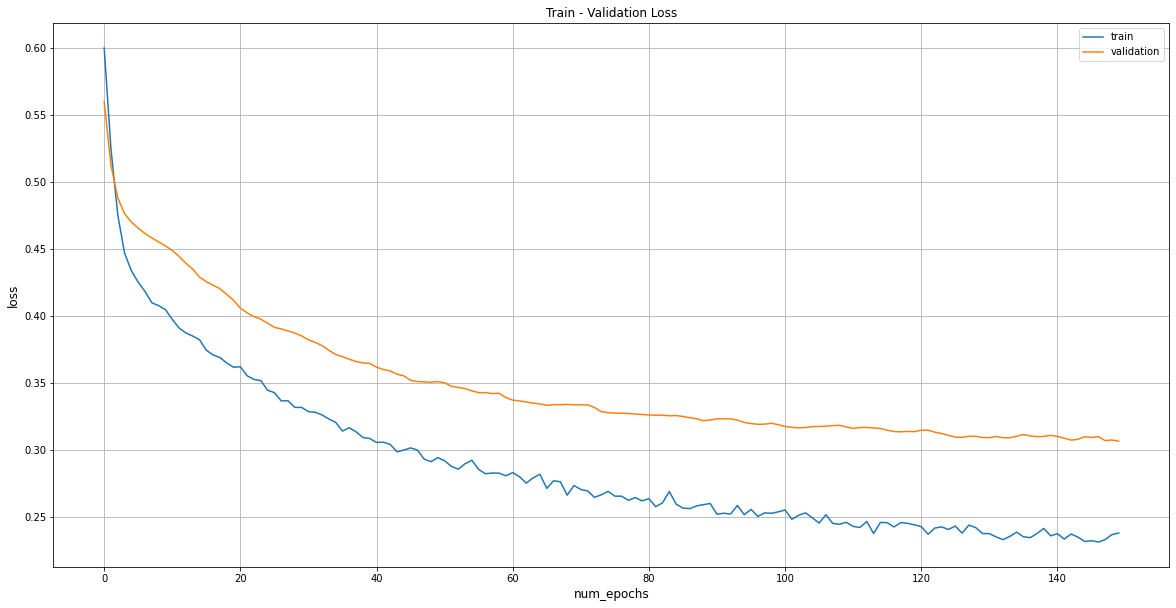

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

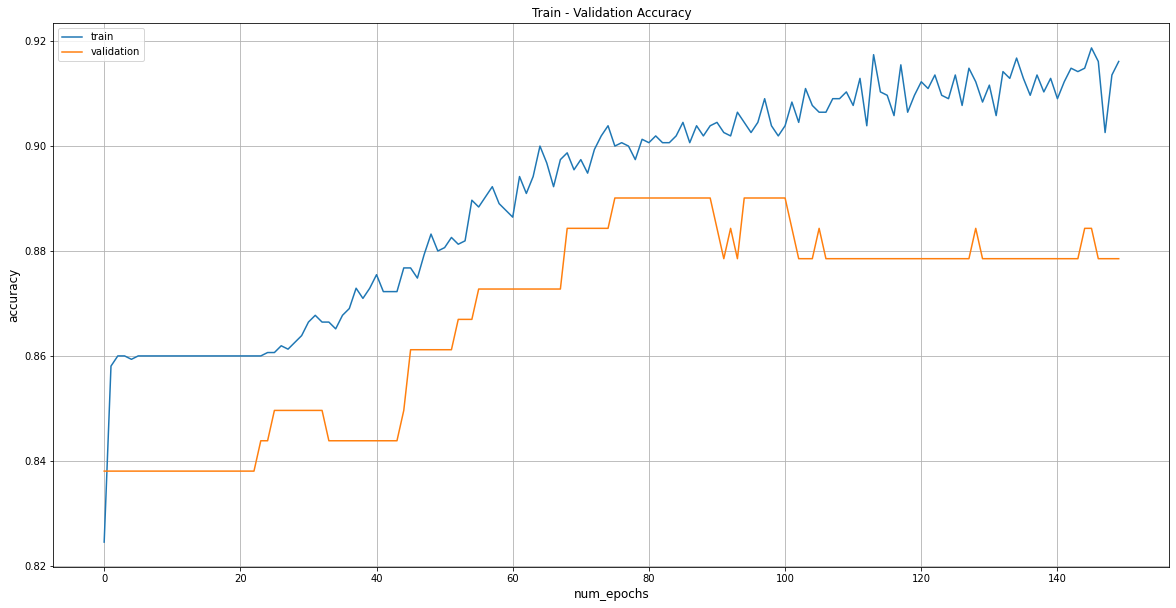

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
model.load_weights(filepath_checkpoint)
model.evaluate(x_test.data, y_test)

14/14 [==============================] - 10s 712ms/step - loss: 0.2414 - accuracy: 0.9005


[0.24144314229488373, 0.9004629850387573]

In [ ]:
# Comparativa con una predicción por clase mayoritaria de train:

pd.Series(y_train).value_counts()/sum(pd.Series(y_train).value_counts())

1.0    0.857889
0.0    0.142111
Name: finanzas_tag_s_n, dtype: float64

In [ ]:
y_pred = model.predict(x_test.data)

In [ ]:
y_pred = y_pred.logits.argmax(axis=1)

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.81      0.45      0.57        65
         1.0       0.91      0.98      0.94       367

    accuracy                           0.90       432
   macro avg       0.86      0.71      0.76       432
weighted avg       0.89      0.90      0.89       432



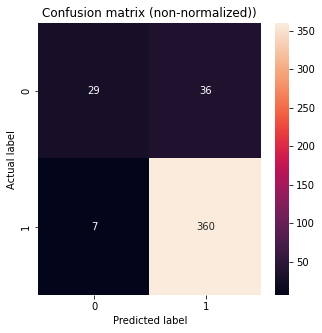

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_test, y_pred)

In [ ]:
def func_apply(row):
    if (not type(row.body_no_entities)==str):    
        row.body_no_entities = str(row.body_no_entities)
    x = tokenizer(row.body_no_entities, padding="max_length", truncation=True, return_tensors="tf")
    y_pred = model.predict(x.data)
    row['finanzas_tag_s_n'] = int(y_pred.logits.argmax(axis=1)[0])    
    row['finanzas_tag_s_n_proba'] = tf.nn.softmax(y_pred.logits).numpy().max(axis=1)[0]
    return row

In [ ]:
# tqdm.pandas()
# df_total_labels["finanzas_tag_s_n_proba"] = np.NaN
# df_total_labels.loc[finance_label, "finanzas_tag_s_n_proba"] = 1.
# df_total_labels.loc[~finance_label] = df_total_labels.loc[~finance_label].progress_apply(lambda row : func_apply(row), axis=1)

In [ ]:
# df_total_labels.to_csv(f'{filepath}_predict_finanzas_tag_s_n.csv', sep=";")

# Transfer Learning con BETO con KFold

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 1...
Epoch 1/70
50/50 [==============================] - 67s 1s/step - loss: 0.5646 - accuracy: 0.7659 - val_loss: 0.5235 - val_accuracy: 0.8136
Epoch 2/70
50/50 [==============================] - 46s 928ms/step - loss: 0.4429 - accuracy: 0.8462 - val_loss: 0.4985 - val_accuracy: 0.8136
Epoch 3/70
50/50 [==============================] - 46s 926ms/step - loss: 0.4233 - accuracy: 0.8462 - val_loss: 0.4811 - val_accuracy: 0.8136
Epoch 4/70
50/50 [==============================] - 46s 926ms/step - loss: 0.4069 - accuracy: 0.8462 - val_loss: 0.4636 - val_accuracy: 0.8136
Epoch 5/70
50/50 [==============================] - 46s 926ms/step - loss: 0.3931 - accuracy: 0.8462 - val_loss: 0.4458 - val_accuracy: 0.8136
Epoch 6/70
50/50 [==============================] - 46s 926ms/step - loss: 0.3808 - accuracy: 0.8462 - val_loss: 0.4299 - val_accuracy: 0.8136
Epoch 7/70
50/50 [==============================] - 46s 927ms/step - loss: 0.3683 - accuracy: 0.8462 - val_loss: 0.4151 -

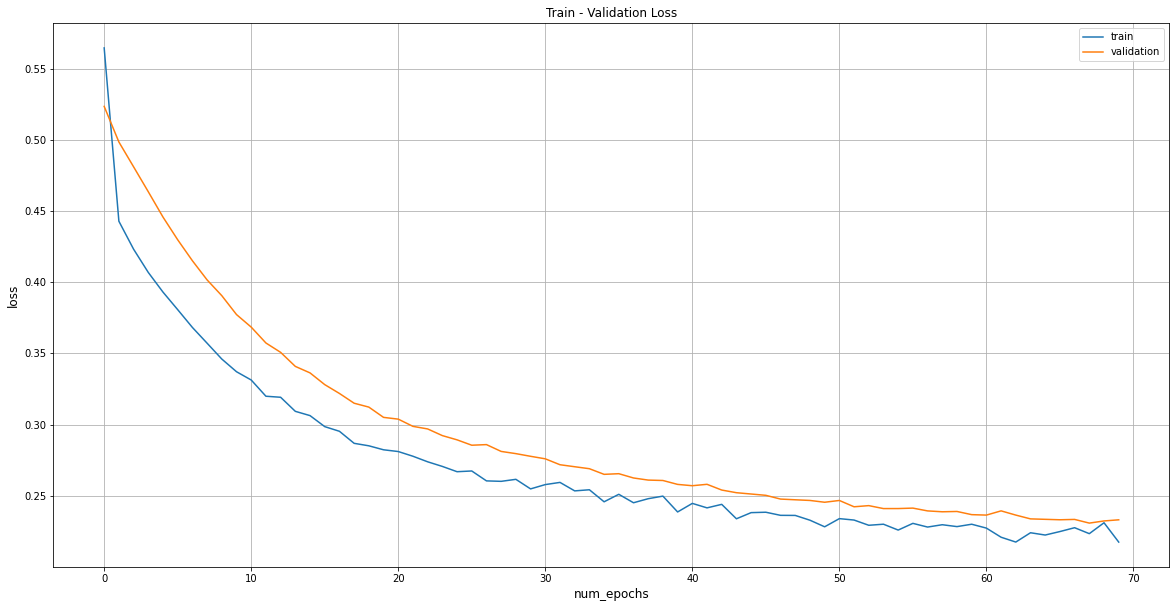

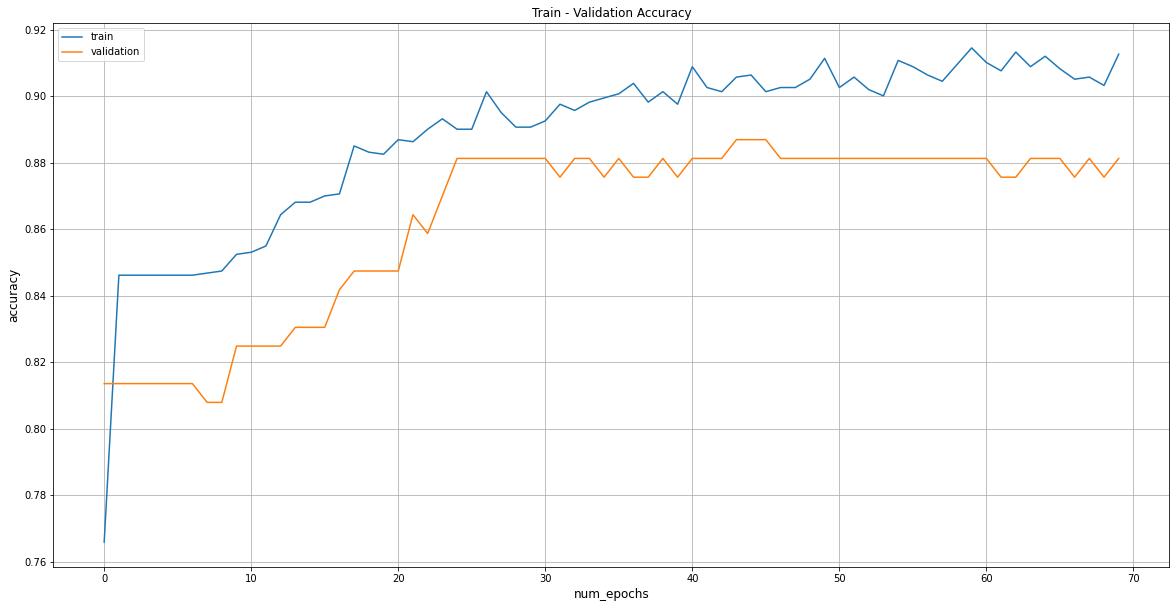

7/7 [==============================] - 5s 647ms/step - loss: 0.2492 - accuracy: 0.8934
Accuracy: 0.893401026725769


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 2...
Epoch 1/70
50/50 [==============================] - 62s 1s/step - loss: 0.5492 - accuracy: 0.8054 - val_loss: 0.5077 - val_accuracy: 0.8079
Epoch 2/70
50/50 [==============================] - 46s 927ms/step - loss: 0.4461 - accuracy: 0.8412 - val_loss: 0.4891 - val_accuracy: 0.8079
Epoch 3/70
50/50 [==============================] - 46s 926ms/step - loss: 0.4287 - accuracy: 0.8412 - val_loss: 0.4717 - val_accuracy: 0.8079
Epoch 4/70
50/50 [==============================] - 46s 927ms/step - loss: 0.4159 - accuracy: 0.8412 - val_loss: 0.4545 - val_accuracy: 0.8079
Epoch 5/70
50/50 [==============================] - 46s 927ms/step - loss: 0.4008 - accuracy: 0.8412 - val_loss: 0.4373 - val_accuracy: 0.8079
Epoch 6/70
50/50 [==============================] - 46s 927ms/step - loss: 0.3895 - accuracy: 0.8412 - val_loss: 0.4203 - val_accuracy: 0.8079
Epoch 7/70
50/50 [==============================] - 46s 927ms/step - loss: 0.3743 - accuracy: 0.8412 - val_loss: 0.4071 -

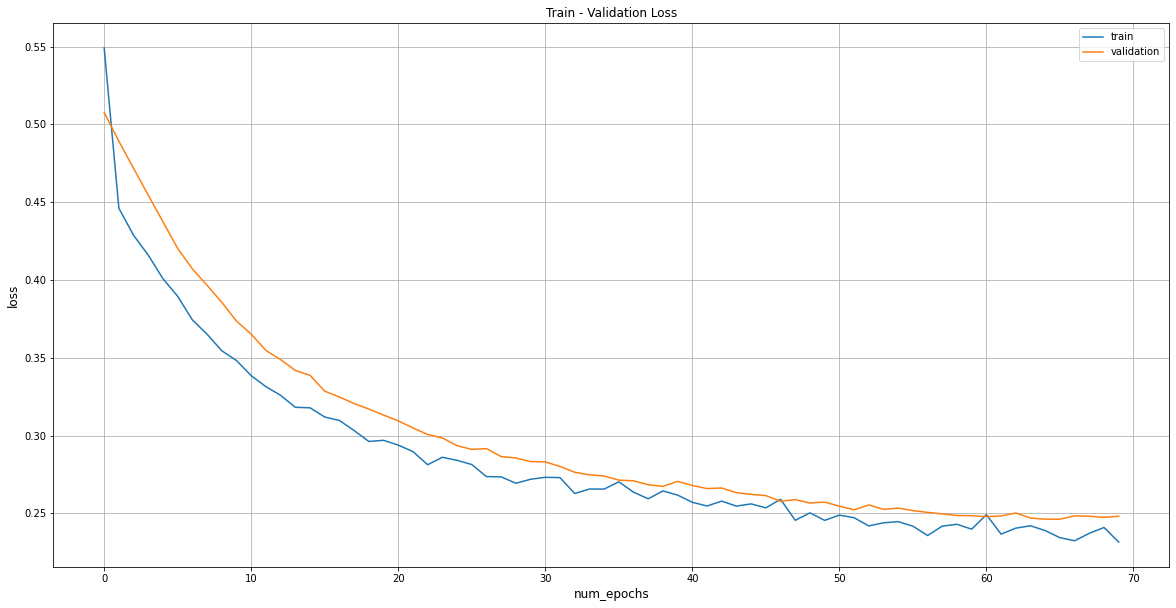

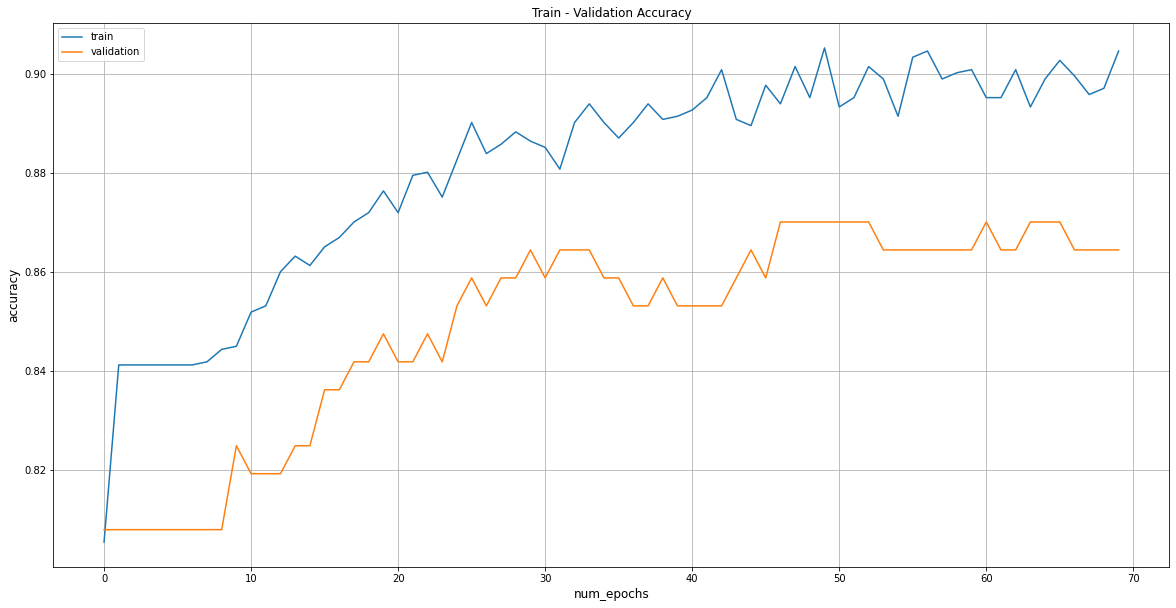

7/7 [==============================] - 5s 648ms/step - loss: 0.2102 - accuracy: 0.9188
Accuracy: 0.9187816977500916


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 3...
Epoch 1/70
50/50 [==============================] - 63s 1s/step - loss: 0.5371 - accuracy: 0.8198 - val_loss: 0.4410 - val_accuracy: 0.8531
Epoch 2/70
50/50 [==============================] - 46s 929ms/step - loss: 0.4440 - accuracy: 0.8399 - val_loss: 0.4064 - val_accuracy: 0.8531
Epoch 3/70
50/50 [==============================] - 46s 929ms/step - loss: 0.4221 - accuracy: 0.8399 - val_loss: 0.3878 - val_accuracy: 0.8531
Epoch 4/70
50/50 [==============================] - 46s 928ms/step - loss: 0.4081 - accuracy: 0.8399 - val_loss: 0.3715 - val_accuracy: 0.8531
Epoch 5/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3920 - accuracy: 0.8399 - val_loss: 0.3557 - val_accuracy: 0.8531
Epoch 6/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3815 - accuracy: 0.8399 - val_loss: 0.3415 - val_accuracy: 0.8531
Epoch 7/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3694 - accuracy: 0.8399 - val_loss: 0.3286 -

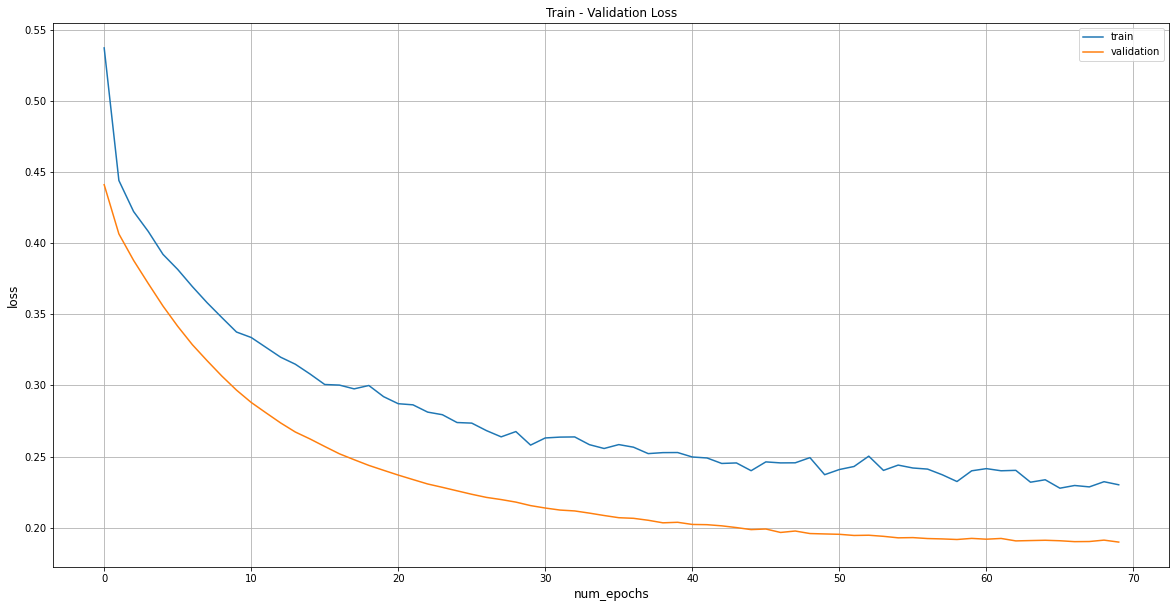

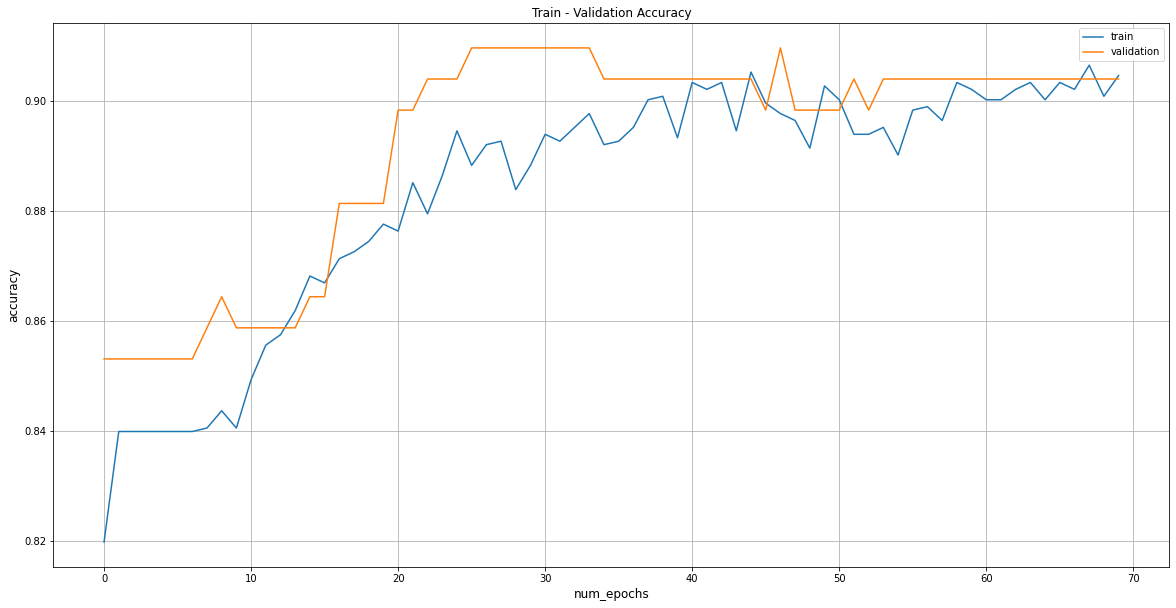

7/7 [==============================] - 5s 645ms/step - loss: 0.2516 - accuracy: 0.8883
Accuracy: 0.8883248567581177


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 4...
Epoch 1/70
50/50 [==============================] - 62s 1s/step - loss: 0.5570 - accuracy: 0.7922 - val_loss: 0.5301 - val_accuracy: 0.7853
Epoch 2/70
50/50 [==============================] - 46s 927ms/step - loss: 0.4312 - accuracy: 0.8512 - val_loss: 0.5221 - val_accuracy: 0.7853
Epoch 3/70
50/50 [==============================] - 46s 927ms/step - loss: 0.4093 - accuracy: 0.8512 - val_loss: 0.5137 - val_accuracy: 0.7853
Epoch 4/70
50/50 [==============================] - 46s 926ms/step - loss: 0.3967 - accuracy: 0.8512 - val_loss: 0.4935 - val_accuracy: 0.7853
Epoch 5/70
50/50 [==============================] - 46s 926ms/step - loss: 0.3845 - accuracy: 0.8512 - val_loss: 0.4776 - val_accuracy: 0.7853
Epoch 6/70
50/50 [==============================] - 46s 926ms/step - loss: 0.3722 - accuracy: 0.8512 - val_loss: 0.4616 - val_accuracy: 0.7853
Epoch 7/70
50/50 [==============================] - 46s 926ms/step - loss: 0.3628 - accuracy: 0.8512 - val_loss: 0.4486 -

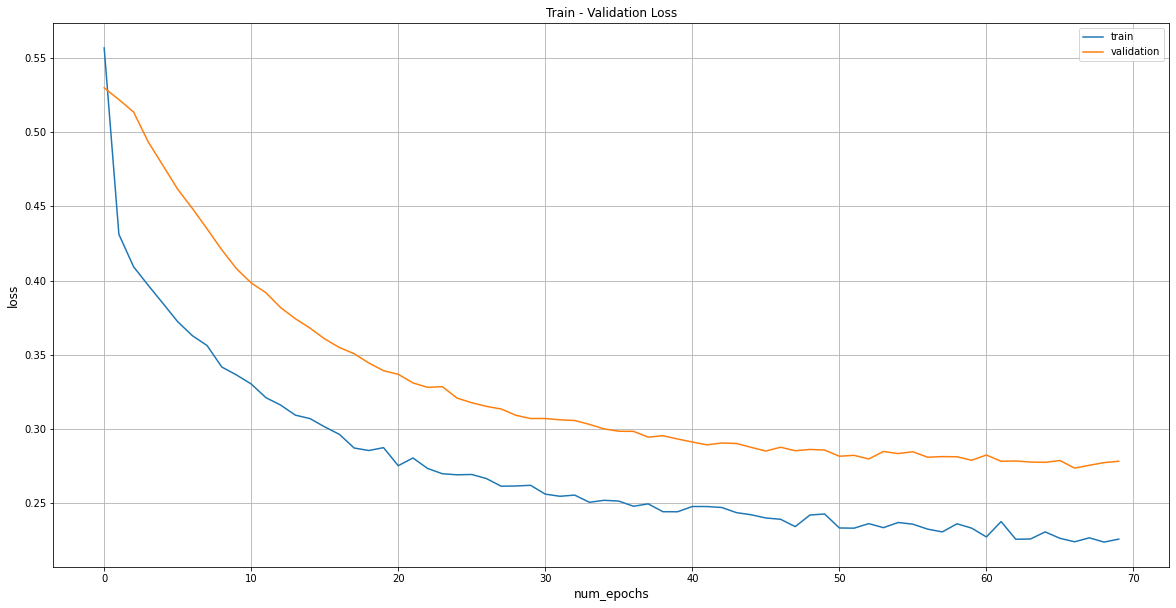

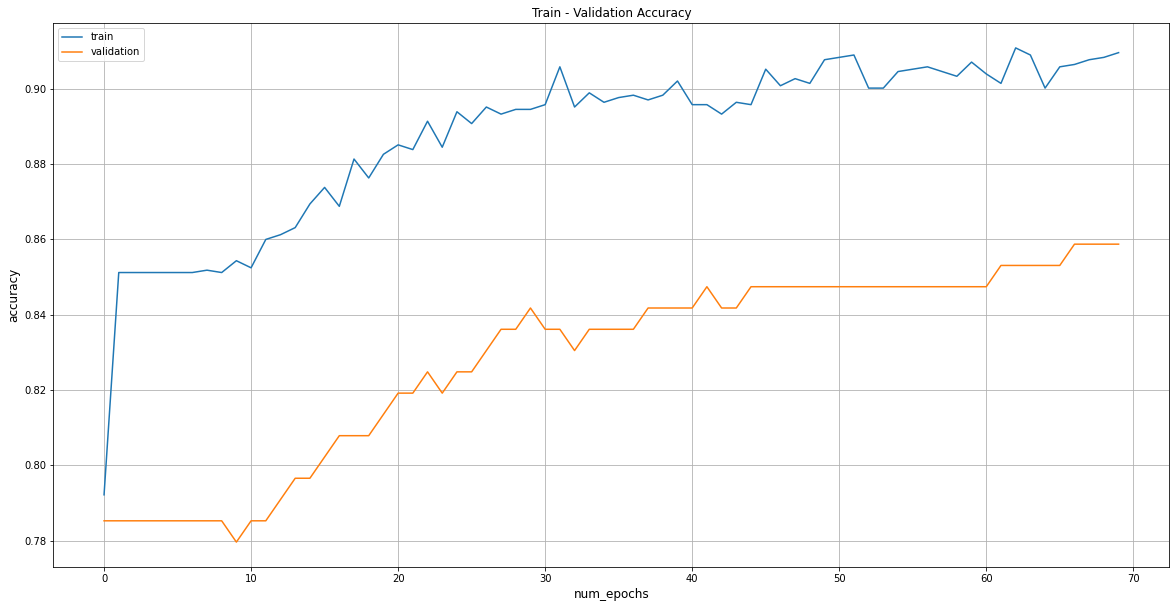

7/7 [==============================] - 5s 648ms/step - loss: 0.2214 - accuracy: 0.8782
Accuracy: 0.8781725764274597


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 5...
Epoch 1/70
50/50 [==============================] - 62s 1s/step - loss: 0.5392 - accuracy: 0.8098 - val_loss: 0.5075 - val_accuracy: 0.8136
Epoch 2/70
50/50 [==============================] - 46s 928ms/step - loss: 0.4436 - accuracy: 0.8424 - val_loss: 0.4843 - val_accuracy: 0.8136
Epoch 3/70
50/50 [==============================] - 46s 927ms/step - loss: 0.4208 - accuracy: 0.8424 - val_loss: 0.4634 - val_accuracy: 0.8136
Epoch 4/70
50/50 [==============================] - 46s 928ms/step - loss: 0.4057 - accuracy: 0.8424 - val_loss: 0.4426 - val_accuracy: 0.8136
Epoch 5/70
50/50 [==============================] - 46s 927ms/step - loss: 0.3905 - accuracy: 0.8424 - val_loss: 0.4219 - val_accuracy: 0.8136
Epoch 6/70
50/50 [==============================] - 46s 927ms/step - loss: 0.3774 - accuracy: 0.8424 - val_loss: 0.4055 - val_accuracy: 0.8136
Epoch 7/70
50/50 [==============================] - 46s 927ms/step - loss: 0.3649 - accuracy: 0.8424 - val_loss: 0.3890 -

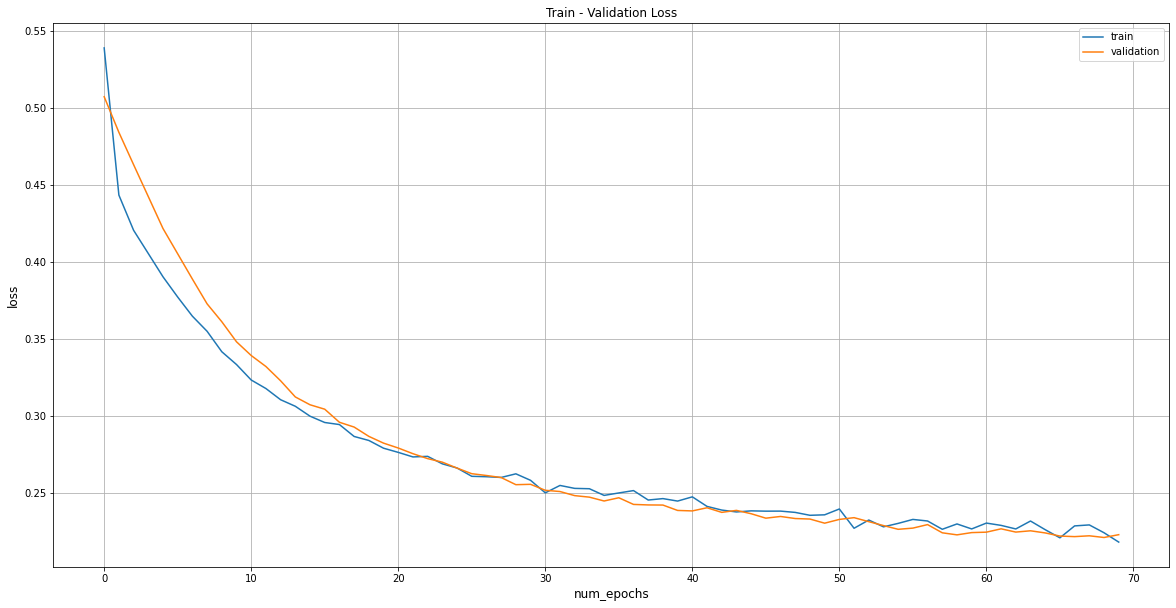

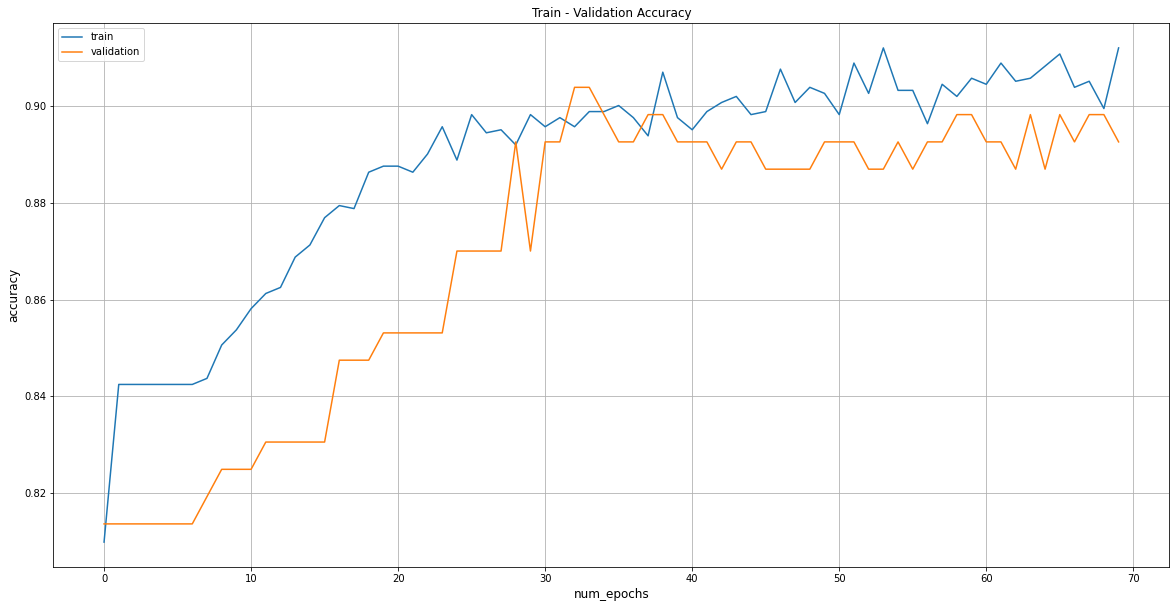

7/7 [==============================] - 5s 647ms/step - loss: 0.2424 - accuracy: 0.9036
Accuracy: 0.903553307056427


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 6...
Epoch 1/70
50/50 [==============================] - 63s 1s/step - loss: 0.5254 - accuracy: 0.8280 - val_loss: 0.4357 - val_accuracy: 0.8644
Epoch 2/70
50/50 [==============================] - 46s 929ms/step - loss: 0.4250 - accuracy: 0.8475 - val_loss: 0.3969 - val_accuracy: 0.8644
Epoch 3/70
50/50 [==============================] - 46s 928ms/step - loss: 0.4068 - accuracy: 0.8475 - val_loss: 0.3769 - val_accuracy: 0.8644
Epoch 4/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3910 - accuracy: 0.8475 - val_loss: 0.3589 - val_accuracy: 0.8644
Epoch 5/70
50/50 [==============================] - 46s 927ms/step - loss: 0.3748 - accuracy: 0.8475 - val_loss: 0.3427 - val_accuracy: 0.8644
Epoch 6/70
50/50 [==============================] - 46s 927ms/step - loss: 0.3633 - accuracy: 0.8481 - val_loss: 0.3276 - val_accuracy: 0.8644
Epoch 7/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3498 - accuracy: 0.8481 - val_loss: 0.3144 -

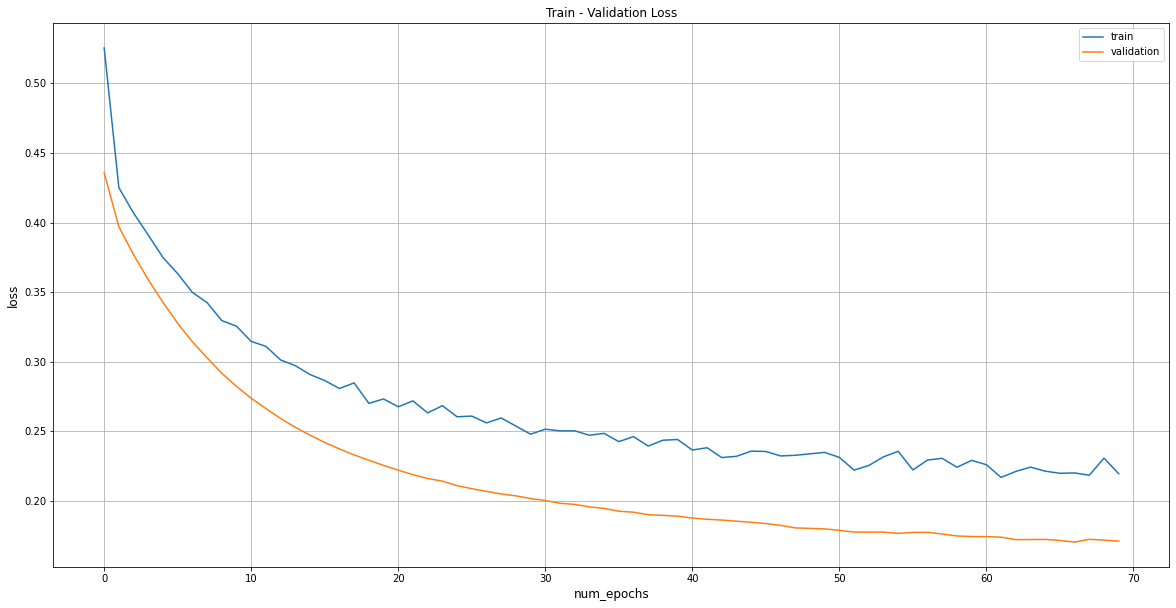

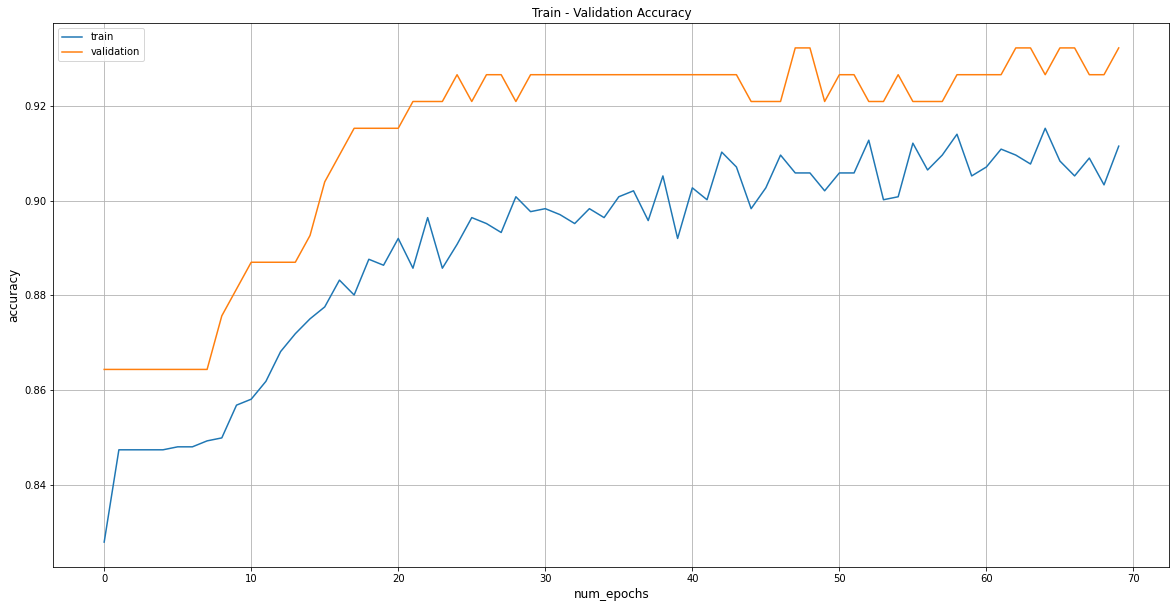

7/7 [==============================] - 5s 647ms/step - loss: 0.3034 - accuracy: 0.8528
Accuracy: 0.8527919054031372


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 7...
Epoch 1/70
50/50 [==============================] - 63s 1s/step - loss: 0.6428 - accuracy: 0.6265 - val_loss: 0.5206 - val_accuracy: 0.8418
Epoch 2/70
50/50 [==============================] - 46s 929ms/step - loss: 0.4702 - accuracy: 0.8412 - val_loss: 0.4653 - val_accuracy: 0.8418
Epoch 3/70
50/50 [==============================] - 46s 927ms/step - loss: 0.4421 - accuracy: 0.8412 - val_loss: 0.4467 - val_accuracy: 0.8418
Epoch 4/70
50/50 [==============================] - 46s 928ms/step - loss: 0.4287 - accuracy: 0.8412 - val_loss: 0.4297 - val_accuracy: 0.8418
Epoch 5/70
50/50 [==============================] - 46s 927ms/step - loss: 0.4166 - accuracy: 0.8412 - val_loss: 0.4138 - val_accuracy: 0.8418
Epoch 6/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3987 - accuracy: 0.8412 - val_loss: 0.3974 - val_accuracy: 0.8418
Epoch 7/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3883 - accuracy: 0.8412 - val_loss: 0.3839 -

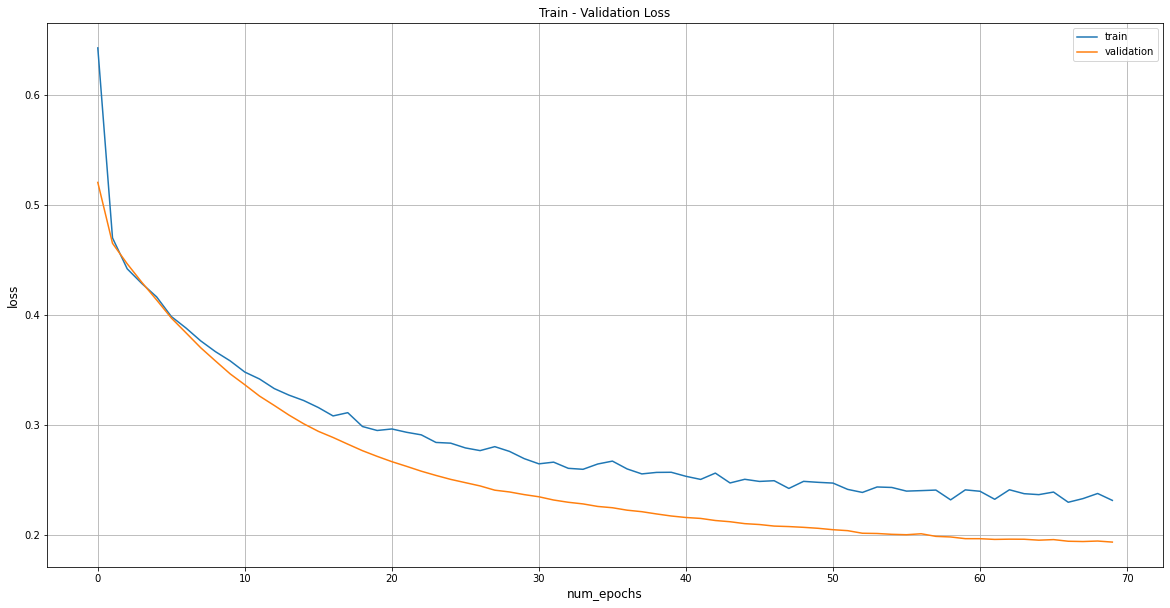

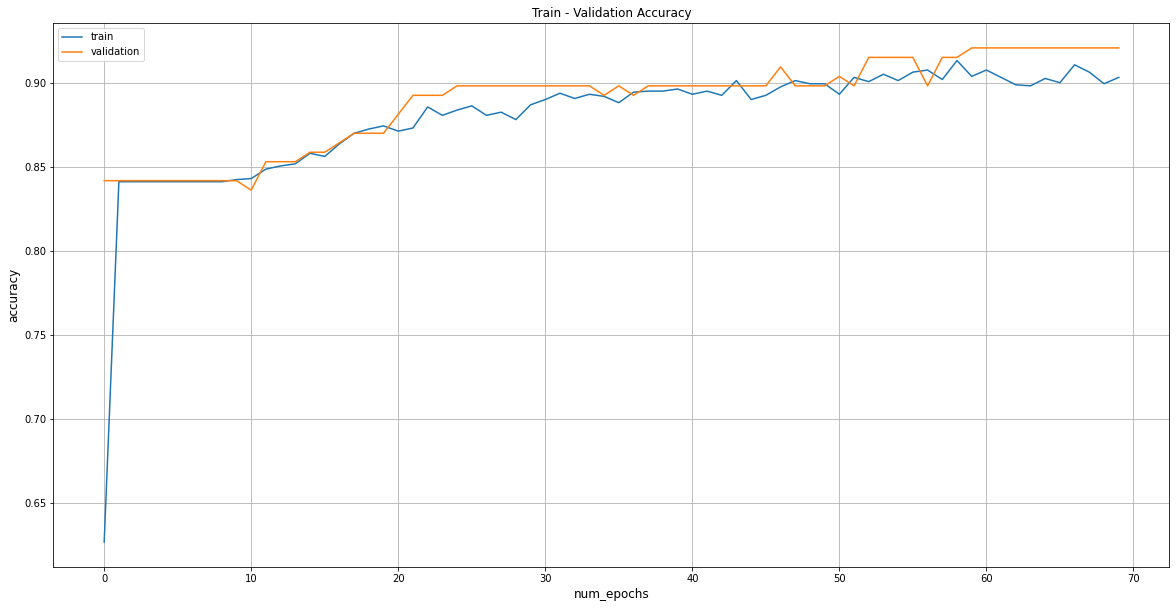

7/7 [==============================] - 5s 650ms/step - loss: 0.1850 - accuracy: 0.9289
Accuracy: 0.9289340376853943


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 8...
Epoch 1/70
50/50 [==============================] - 62s 1s/step - loss: 0.5059 - accuracy: 0.8393 - val_loss: 0.4963 - val_accuracy: 0.8090
Epoch 2/70
50/50 [==============================] - 46s 928ms/step - loss: 0.4246 - accuracy: 0.8475 - val_loss: 0.4805 - val_accuracy: 0.8090
Epoch 3/70
50/50 [==============================] - 46s 928ms/step - loss: 0.4075 - accuracy: 0.8475 - val_loss: 0.4634 - val_accuracy: 0.8090
Epoch 4/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3890 - accuracy: 0.8475 - val_loss: 0.4432 - val_accuracy: 0.8090
Epoch 5/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3738 - accuracy: 0.8475 - val_loss: 0.4252 - val_accuracy: 0.8090
Epoch 6/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3610 - accuracy: 0.8481 - val_loss: 0.4067 - val_accuracy: 0.8090
Epoch 7/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3486 - accuracy: 0.8493 - val_loss: 0.3900 -

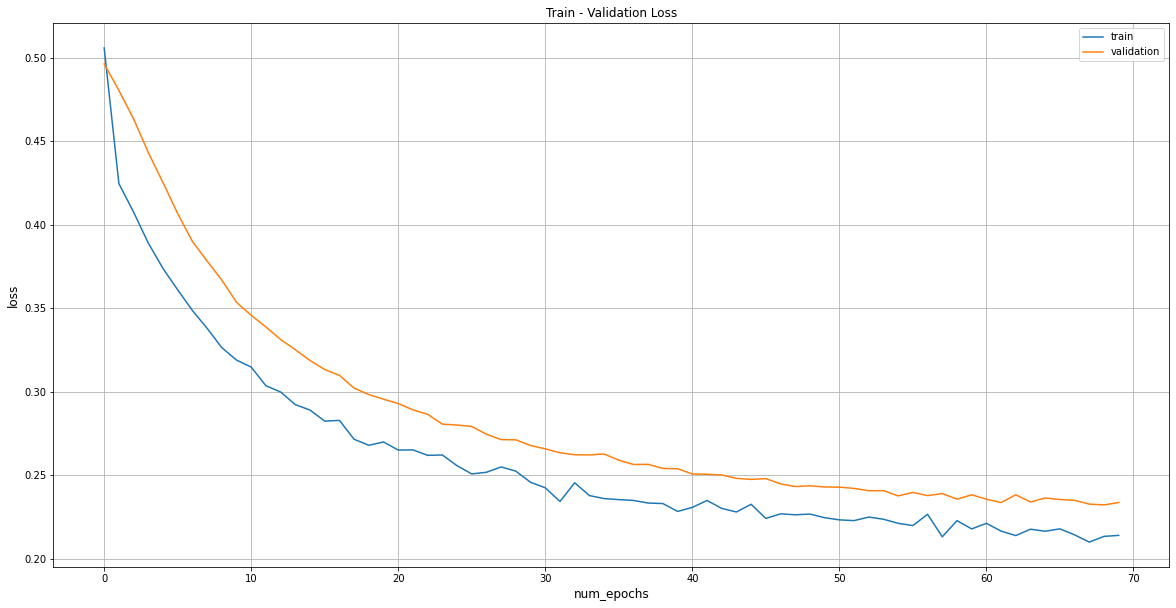

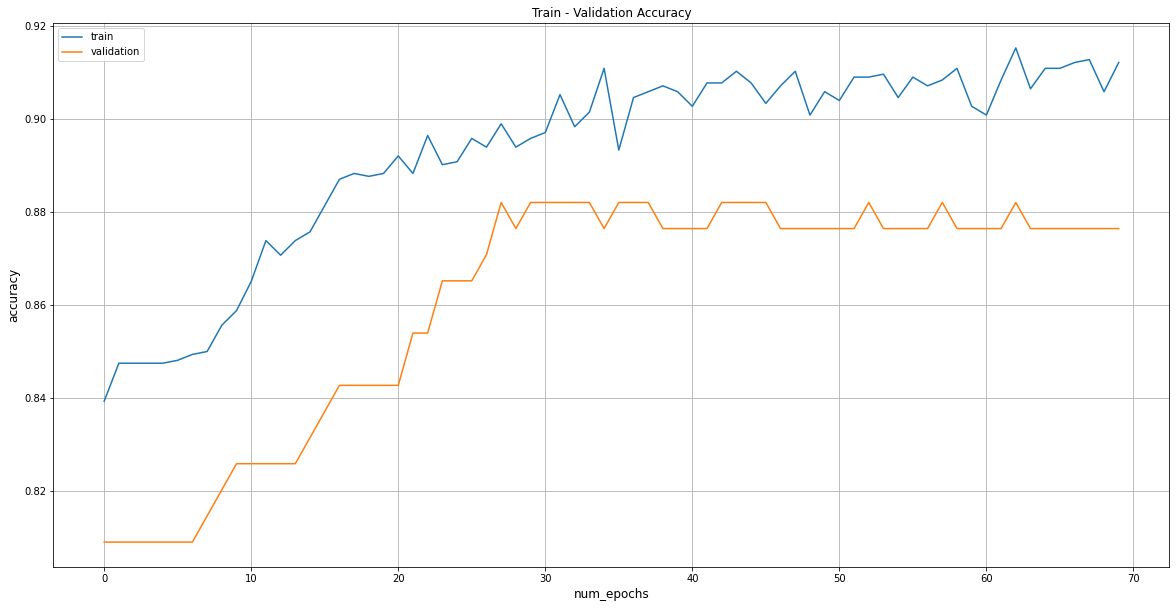

7/7 [==============================] - 5s 642ms/step - loss: 0.2738 - accuracy: 0.9031
Accuracy: 0.9030612111091614


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 9...
Epoch 1/70
50/50 [==============================] - 63s 1s/step - loss: 0.5676 - accuracy: 0.7753 - val_loss: 0.5228 - val_accuracy: 0.8034
Epoch 2/70
50/50 [==============================] - 46s 930ms/step - loss: 0.4443 - accuracy: 0.8443 - val_loss: 0.4980 - val_accuracy: 0.8034
Epoch 3/70
50/50 [==============================] - 46s 929ms/step - loss: 0.4192 - accuracy: 0.8443 - val_loss: 0.4794 - val_accuracy: 0.8034
Epoch 4/70
50/50 [==============================] - 46s 929ms/step - loss: 0.4075 - accuracy: 0.8443 - val_loss: 0.4635 - val_accuracy: 0.8034
Epoch 5/70
50/50 [==============================] - 46s 927ms/step - loss: 0.3915 - accuracy: 0.8443 - val_loss: 0.4428 - val_accuracy: 0.8034
Epoch 6/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3817 - accuracy: 0.8443 - val_loss: 0.4244 - val_accuracy: 0.8034
Epoch 7/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3697 - accuracy: 0.8443 - val_loss: 0.4097 -

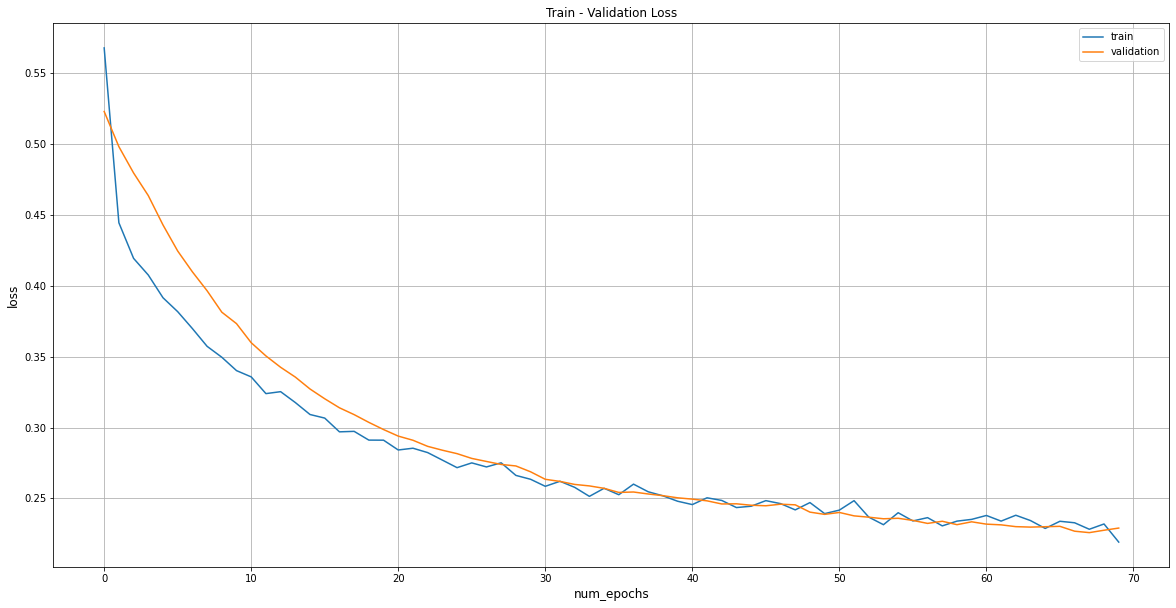

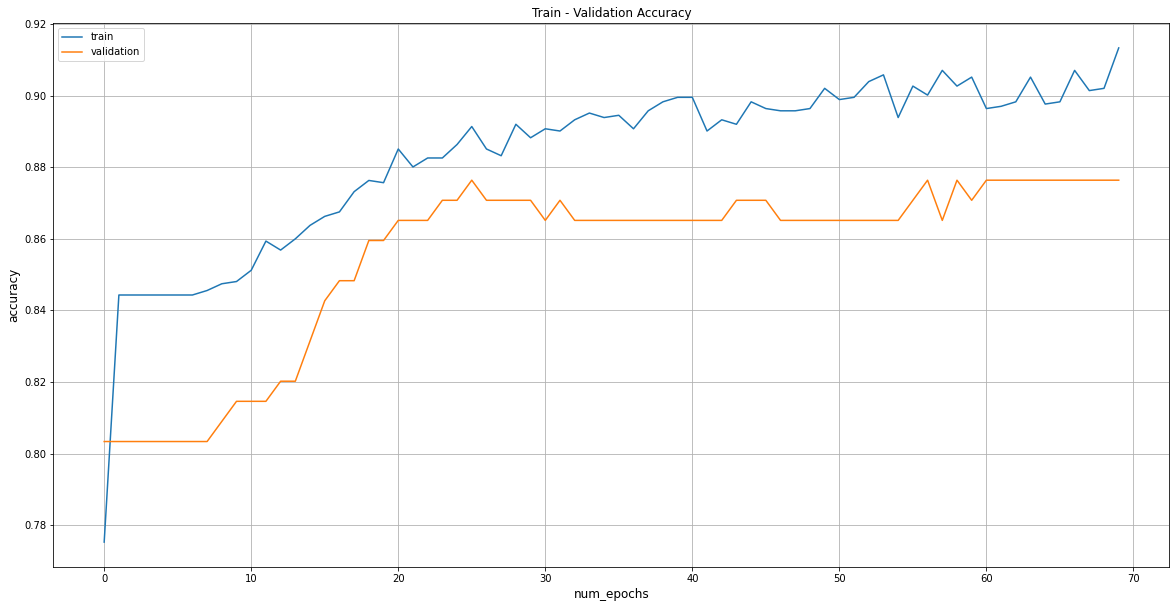

7/7 [==============================] - 5s 642ms/step - loss: 0.1995 - accuracy: 0.9082
Accuracy: 0.9081632494926453


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 10...
Epoch 1/70
50/50 [==============================] - 63s 1s/step - loss: 0.5825 - accuracy: 0.7602 - val_loss: 0.5009 - val_accuracy: 0.8315
Epoch 2/70
50/50 [==============================] - 46s 929ms/step - loss: 0.4501 - accuracy: 0.8449 - val_loss: 0.4604 - val_accuracy: 0.8315
Epoch 3/70
50/50 [==============================] - 46s 928ms/step - loss: 0.4261 - accuracy: 0.8449 - val_loss: 0.4414 - val_accuracy: 0.8315
Epoch 4/70
50/50 [==============================] - 46s 929ms/step - loss: 0.4085 - accuracy: 0.8449 - val_loss: 0.4240 - val_accuracy: 0.8315
Epoch 5/70
50/50 [==============================] - 46s 929ms/step - loss: 0.3985 - accuracy: 0.8449 - val_loss: 0.4074 - val_accuracy: 0.8315
Epoch 6/70
50/50 [==============================] - 46s 928ms/step - loss: 0.3846 - accuracy: 0.8449 - val_loss: 0.3931 - val_accuracy: 0.8315
Epoch 7/70
50/50 [==============================] - 46s 929ms/step - loss: 0.3731 - accuracy: 0.8449 - val_loss: 0.3771 

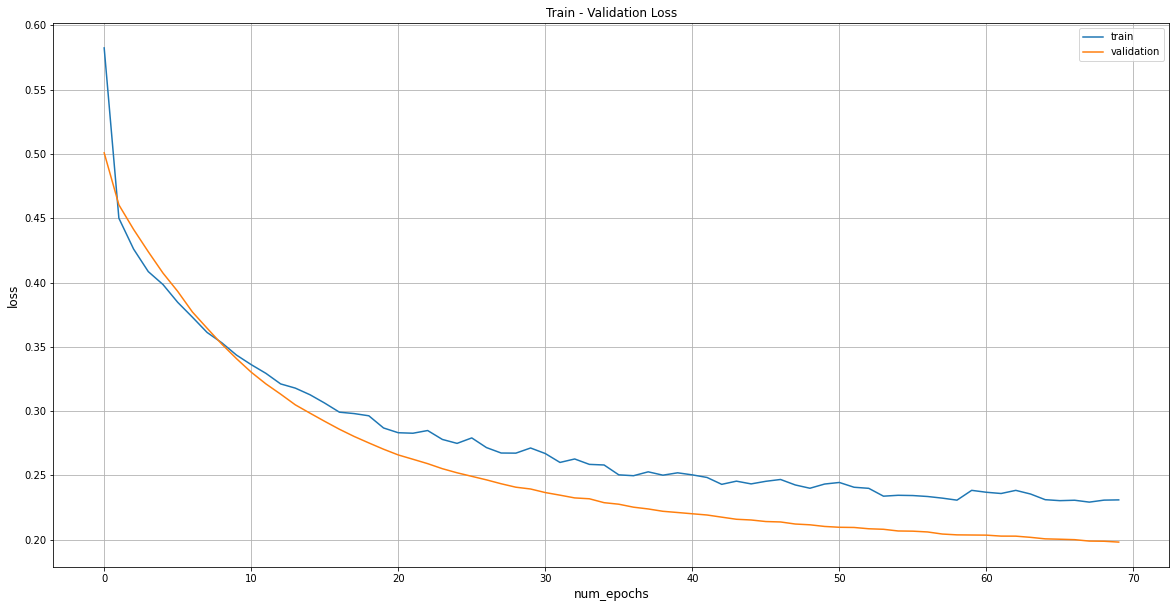

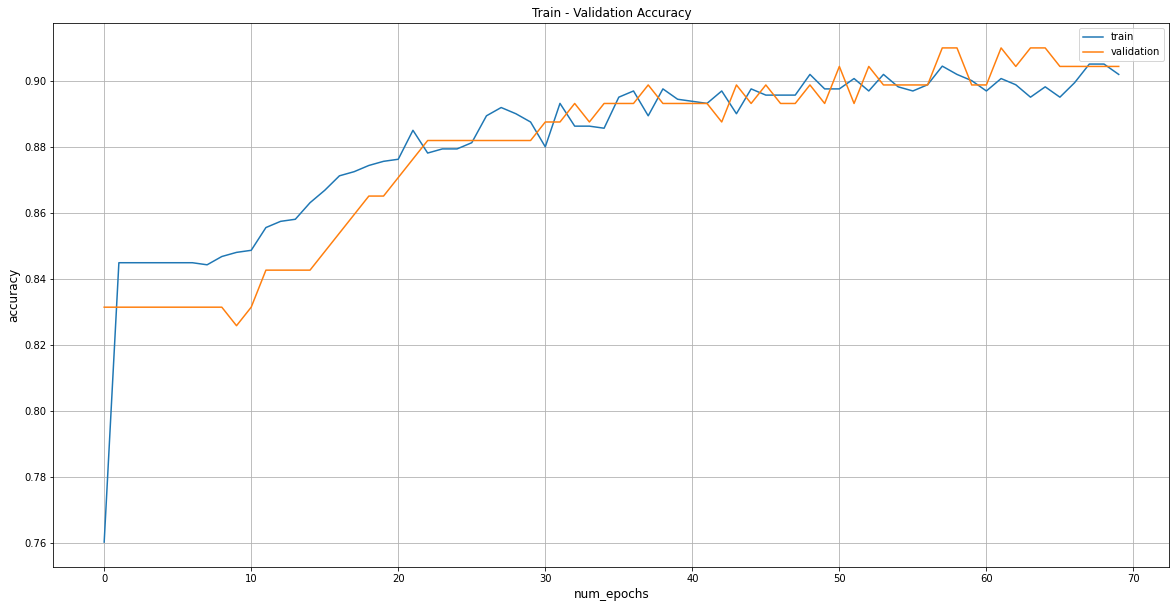

7/7 [==============================] - 5s 642ms/step - loss: 0.2428 - accuracy: 0.8929
Accuracy: 0.8928571343421936


accuracy    0.896804
dtype: float64

In [ ]:
N_EPOCAS = 70
kfold = KFold(n_splits=10, shuffle=True)
acc = []
fold = 1
directory_checkpoint = "tfm/checkpoints/finanzas_tag_s_n/"
for train, test in kfold.split(dataset_labels.body_no_entities):
    
    fold_train_x = dataset_labels.body_no_entities.values[train]
    textos_train = tokenizer(fold_train_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
     
    fold_train_y = dataset_labels.finanzas_tag_s_n.values[train]
            
    model_checkpoint_callback = ModelCheckpoint(
        filepath=f'{directory_checkpoint}/fold_{fold}',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')
    
    # Para cada Fold se entrena de nuevo
    model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)
    model.layers[0].trainable=False
    model.layers[-1].activation=tf.keras.activations.softmax
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    print(f"Starting with Fold {fold}...")

    hist = model.fit(
        textos_train.data,
        fold_train_y,
        validation_split=0.1,
        epochs=N_EPOCAS,
        callbacks=[model_checkpoint_callback, early_stopping]
        )
    
    fold_test_x = dataset_labels.body_no_entities.values[test]
    textos_test = tokenizer(fold_test_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
    
    fold_test_y = dataset_labels.finanzas_tag_s_n.values[test]

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Loss")
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Accuracy")
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    model.load_weights(f'{directory_checkpoint}/fold_{fold}')
    i_acc  = model.evaluate(textos_test.data, fold_test_y)
    print("Accuracy:", i_acc[1])
    acc.append(i_acc[1])
    
    fold += 1
result = pd.DataFrame({'accuracy':acc})
result.mean()

In [ ]:
result

,accuracy
0,0.893401
1,0.918782
2,0.888325
3,0.878173
4,0.903553
5,0.852792
6,0.928934
7,0.903061
8,0.908163
9,0.892857


In [ ]:
result.mean()

accuracy    0.896804
dtype: float64

In [ ]:
result

,accuracy
0,0.902778
1,0.921296
2,0.875000
3,0.875000
4,0.884259
5,0.912037
6,0.902326
7,0.911628
8,0.925581
9,0.939535


In [ ]:
result.mean()

accuracy    0.904944
dtype: float64